# Radio Emission of Air Showers
In these excercises we show that with a rather simple model we can investigate conceptual the signal distribution of radio signals from air showers.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from math import * 
from scipy import signal
from scipy.interpolate import interp1d
%matplotlib inline

### Some helper functions to setup the problem
We assume that the radio signal from air showers can be understood as a set of transmitters emitting a signal as the air shower propagated through the atmosphere (vertically, moving downwards). For convience we make an impulse signal of a certain frequency (sin-wave convolved with a gaussian funcion), and assume that the signal strength is indepedent of the location. The emitted signals are received by an several antennas placed along the x-axis. 

In [7]:
#An antenna is both a receiver and transmitter
class Antenna:
    def __init__(self, loc,time=[],amp=[]):
        self.loc=loc
        self.time=time
        self.amp=amp
#speed of light (m/ns)
speed_of_light=0.299792458
#refractive indexof air (1atm, 20 deg C)
refr_air=1.+289e-6
#dist between two points
def dist (p1,p2):
    return sqrt((p1[0]-p2[0])**2+
                (p1[1]-p2[1])**2+
                (p1[2]-p2[2])**2)
#transmit signals
def TransmitAndReceive(trans,receiv,nref=refr_air):
    #speed of light in ns/m
    speed = speed_of_light/nref
    #loop over all receivers
    for re_ in receiv:
        #transmit all signals
        t_min = 1e9 
        t_max = -1e9
        ts_ = [] #time series
        as_ = [] #amplitude series
        for tr_ in trans:
            d_=dist(tr_.loc,re_.loc)
            t_prop=d_/speed
            ts_.append(np.add(tr_.time,t_prop))
            if (d_ != 0.):
                as_.append(tr_.amp)
            if (tr_.time[0] + t_prop < t_min):
                t_min = tr_.time[0] + t_prop
            if (tr_.time[-1] + t_prop > t_max):     
                t_max=tr_.time[-1] + t_prop        
        #interpolate and add signals at receiver
        dt = 0.1
        re_.time = np.arange(t_min+1,t_max-1,dt)
        re_.amp = np.zeros(len(re_.time))        
        for t_r,a_r in zip (ts_,as_):
            f = interp1d(t_r,a_r,assume_sorted=True,fill_value="extrapolate")
            re_.amp = np.add(re_.amp,f(re_.time))    

#pulsed signal with certain frequency
#gaus * sin
def signal(t_ns,f_MHz,offset_ns=0):
    f_GHz=f_MHz/1.e3
    sigma_ns=1./(2*f_GHz)
    norm=np.exp(-np.power((t_ns-offset_ns),2)/(2.*sigma_ns**2.))
    return norm*np.cos(2.*pi*f_GHz*t_ns)    

#transmitters along shower axis for vertical air shower
def make_transmitters(t,Ex,z_start=10e3,z_stop=5e3,dz=50):
    transmitters =[]    
    z=np.arange(z_start,z_stop,-dz)
    for z_ in z:
        #[x,y,z,t]
        #t = l/c
        loc=[0,0,z_]
        t_ = (z_start-z_)/speed_of_light
        tr = Antenna(loc,np.add(t,t_),Ex)
        transmitters.append(tr)
    return transmitters
#lets put the receiving antennas on a line
receivers_line = []
x=np.arange(0,1001,10)
for x_ in x:
    re = Antenna([x_,0,0])
    receivers_line.append(re)
#lets put the receiving antennas in an array
# receivers_xaxis = []
# x=np.arange(-600,601,50)
# for x_ in x:
#     re = Antenna([x_,0,0])
#     receivers_array.append(re)          

# Example, the lateral distribution of 30 MHz signal 

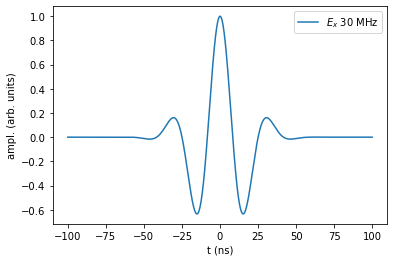

Text(0, 0.5, 'ampl. (arb. units)')

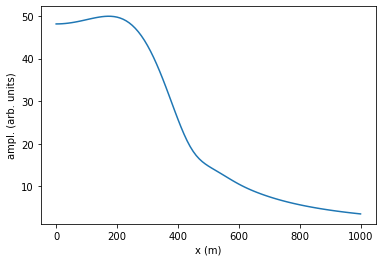

In [8]:
#Example of 30 MHz pulsed signal
#time axis of signal
t=np.arange(-100,100,0.1)
#Get impulsive signal of 30 MHz
Ex_30=signal(t,30)
plt.plot(t,Ex_30,label='$E_{x}$ 30 MHz')
plt.legend()
plt.xlabel('t (ns)')
plt.ylabel('ampl. (arb. units)')
plt.show()
#lets start an air shower at 10km altitude
#and transmit a signal every 100m until 5km altitutde
z_start =10000
z_stop =5000
dz=100
transmitters = make_transmitters(t,Ex_30,z_start,z_stop,dz)
#propagate the signal to to receivers
TransmitAndReceive(transmitters,receivers_line,refr_air)
x = []
y = []
for r in  receivers_line:
    x.append(r.loc[0])
    y.append(np.max(r.amp))
plt.plot(x,y)
plt.xlabel('x (m)')
plt.ylabel('ampl. (arb. units)')

1. Plot the signal pattern for a 300 MHz signal and estimate the location of the maximum. 
2. Calculate the Cherenkov Angle for air (1 atm, 20 deg C). How does the location of the maximum compare to the Cherenkov Angle?
3. The refractivity (n_rf-1) is (roughly) proportional to the density of the atmosphere, repeat 1 and 2, but for an refractive index at 7.5km. The density of the atmosphere is exponential with a scale height of 8km.

Max of radiation patern  170  m
Cherenkov angle (1atm, 20C) (deg): 1.377318122605811
Expected x-location of Cherenkov radiation at 7.5km altitutde 180.32525629053356  m
Cherenkov angle at 7.5km (deg): 0.8619667922614229
Max of radiation patern  110  m
Expected x-location of Cherenkov radiation at 7.5km altitutde 112.83970226647891  m


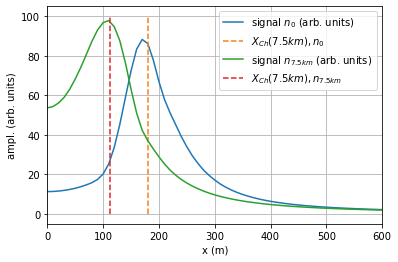

In [17]:
#1)
Ex_300 = signal(t,300)
transmitters = make_transmitters(t,Ex_300)
TransmitAndReceive(transmitters,receivers_line)
x = []
y = []
for r in  receivers_line:
    x.append(r.loc[0])
    y.append(np.max(r.amp))
plt.plot(x,y,label=r'signal $n_{0}$ (arb. units) ')
npy=np.array(y)
npx=np.array(x)
loc_max=npx[(y==np.max(y))]
print('Max of radiation patern ',loc_max[0]," m")

#2)
theta_c = acos(1./refr_air)
print('Cherenkov angle (1atm, 20C) (deg):',degrees(theta_c))
x_7500m=tan(theta_c)*7.5e3
print('Expected x-location of Cherenkov radiation at 7.5km altitutde',x_7500m,' m')
plt.plot([x_7500m,x_7500m],[0,100],'--',label=r'$X_{Ch} (7.5km), n_{0}$')
plt.xlim(0,600)
plt.xlabel('x (m)')
plt.ylabel('ampl. (arb. units)')

#3
refr_7500m=1+(refr_air-1)*exp(-7500./8000)
theta_c = acos(1./refr_7500m)
print('Cherenkov angle at 7.5km (deg):',degrees(theta_c))
TransmitAndReceive(transmitters,receivers_line,refr_7500m)
x = []
y = []
for r in  receivers_line:
    x.append(r.loc[0])
    y.append(np.max(r.amp))
plt.plot(x,y,label=r'signal $n_{7.5km}$ (arb. units) ')
npy=np.array(y)
npx=np.array(x)
loc_max=npx[(y==np.max(y))]
print('Max of radiation patern ',loc_max[0]," m")
x_7500m=tan(theta_c)*7.5e3
plt.plot([x_7500m,x_7500m],[0,100],'--',label=r'$X_{Ch} (7.5km), n_{7.5km}$')
print('Expected x-location of Cherenkov radiation at 7.5km altitutde',x_7500m,' m')
plt.grid()
plt.legend()
plt.savefig('ldfs.pdf')

3. Show  interference between two emission effects along the x-axis (positive and negativa values), assuming geommagnetic field is horzontal going from -y,y (South to North).  And a relative fraction of Askaryan Radiation = 0.12 Geomagnetic Radiation. Take the signal 300 MHz signal.
4. At x=0, this will lead to a discontinuity, i.e. the Askaryan contribution should go to zero for small core distances. Add a function that corrects for the discontinuity but that will lead to 0.12 for large core distances

Text(0, 0.5, 'ampl. (arb. units)')

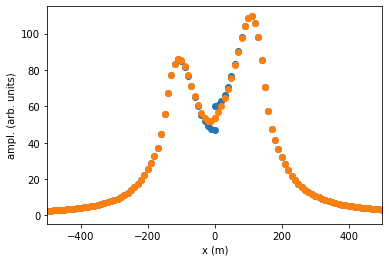

In [13]:
#Polarization geomagnetic  -v x B = -x-direction
transmitters = make_transmitters(t,Ex_300)
TransmitAndReceive(transmitters,receivers_line,refr_7500m)
x = []
y = []
alpha_GM=90
#first negative x receiver coordinates values
for r in  receivers_line:
    x.append(-r.loc[0])
    val = np.max(r.amp);
    #for x < 0
    #charge excess is positive
    #geomagnetic is negative    
    val = -val*sin(radians(alpha_GM)) + 0.12*val;
    y.append((val*val)**0.5)
#first negative x receiver coordinates values
for r in  receivers_line:
    x.append(r.loc[0])
    val = np.max(r.amp);
    #for x < 0
    #charge excess is positive
    #geomagnetic is negative    
    val = -val*sin(radians(alpha_GM)) - 0.12*val;
    y.append((val*val)**0.5)
plt.xlim(-500,500)
plt.plot(x,y,"o")

#adding a scaling factor for the Askaryan component
#near the core
x = []
y = []
alpha_GM=90
#first negative x receiver coordinates values
for r in  receivers_line:
    x.append(-r.loc[0])
    val = np.max(r.amp);
    #for x < 0
    #charge excess is positive
    #geomagnetic is negative    
    val = -val*sin(radians(alpha_GM)) + 0.12*(1-exp(-r.loc[0]/20))*val;
    y.append((val*val)**0.5)
#first negative x receiver coordinates values
for r in  receivers_line:
    x.append(r.loc[0])
    val = np.max(r.amp);
    #for x < 0
    #charge excess is positive
    #geomagnetic is negative    
    val = -val*sin(radians(alpha_GM)) - 0.12*(1-exp(-r.loc[0]/20))*val;
    y.append((val*val)**0.5)
plt.xlim(-500,500)
plt.plot(x,y,"o")
plt.xlabel('x (m)')
plt.ylabel('ampl. (arb. units)')